# Quasi-Monte Carlo Generators, Randomizers, and Fast Transforms

## Setup

In [1]:
import qmcpy as qp
import numpy as np
import timeit
from matplotlib import pyplot
from collections import OrderedDict
import os
import time
import itertools

In [2]:
pyplot.style.use("seaborn-v0_8-pastel")
colors = [
    "xkcd:purple",
    "xkcd:green",
    "xkcd:blue",
    "xkcd:pink",
    "xkcd:brown",
    "xkcd:red",
    "xkcd:orange",
    "xkcd:violet",
    "xkcd:grey",
]

## Snippets

In [3]:
%%time 
lattice = qp.Lattice(
    dimension = 52,
    randomize = "shift", # for unrandomized lattice set randomize = False
    replications = 16, # R
    order = "natural", # also supports "linear" and "Gray" for Gray code
    seed = None, # pass integer seed for reproducibility
    generating_vector = "LDData:mps.exod2_base2_m20_CKN.txt")
x = lattice(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 950 ms, sys: 94 ms, total: 1.04 s
Wall time: 1.05 s


In [4]:
%%time
dnb2 = qp.DigitalNetB2(
    dimension = 52, 
    randomize = "LMS_DS", # Matousek's LMS with a digital shift
    # randomize options are [LMS_DS, NUS, DS, LMS, False]
    t_lms = 64, # number of LMS bits i.e. number of rows in S_j
    alpha = 2, # interlacing factor for higher order digital nets
    replications = 16, # R
    graycode = False, # use natural order instead of Gray code order 
    seed = None, # pass integer seed for reproducibility
    generating_matrices = "LDData:mps.sobol_Cs.txt")
x = dnb2(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 887 ms, sys: 320 ms, total: 1.21 s
Wall time: 1.21 s


In [5]:
%%time 
halton = qp.Halton(
    dimension = 52, 
    randomize = "LMS_PERM", # Matousek's LMS with a digital permutation
    # randomize options are [LMS_PERM, LMS_DS, LMS, PERM, DS, NUS, QRNG, FALSE]
    t_lms = 64, # number of LMS bits i.e. number of rows in S_j
    replications = 16, # R
    seed = None) # pass integer seed for reproducibility
x = halton(2**10) # a numpy.ndarray with shape 16 x 1024 x 52

CPU times: user 1.35 s, sys: 284 ms, total: 1.63 s
Wall time: 1.63 s


In [6]:
%%time
d = 5 # dimension
n = 2**20 # 2^20 points
dd_obj = qp.Lattice(dimension=d, seed=7) # defaults to natural ordering with a single random shift 
kernel_obj = qp.KernelShiftInvar( # matching kernel 
    dimension = d,
    lengthscales = 0.1*np.ones(d,dtype=float), # product weights
    alpha = 4*np.ones(d,dtype=int)) # smoothness parameters
K = qp.FastGramMatrixLattice( # n x n Gram matrix
    dd_obj = dd_obj, 
    kernel_obj = kernel_obj, 
    n1 = n, n2 = n)
y = np.random.rand(n) # get a random length n vector  
a = K@y # compute the matrix-vector product a=Ky 
b = K.solve(y) # solve linear system Kb=y for b

CPU times: user 1.53 s, sys: 114 ms, total: 1.64 s
Wall time: 1.64 s


## Pointsets

In [7]:
m = 13 # n = 2^m
n = 2**m # number of points
d = 2 # dimensions

In [8]:
pointsets = OrderedDict({
    "IID": qp.IIDStdUniform(d).gen_samples(n),
    "Lattice + Shift": qp.Lattice(d).gen_samples(n),
    r"DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS").gen_samples(n),
    r"DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS").gen_samples(n),
    "Halton + LMS + DP": qp.Halton(d,randomize="LMS_PERM").gen_samples(n),
    "Halton + NUS": qp.Halton(d,randomize="NUS").gen_samples(n),
    r"HO${}_2$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=2).gen_samples(n),
    r"HO${}_2$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=2).gen_samples(n),
    r"HO${}_3$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=3).gen_samples(n),
    r"HO${}_3$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=3).gen_samples(n),
    r"HO${}_4$ DN${}_{2}$ + LMS + DS": qp.DigitalNetB2(d,randomize="LMS_DS",alpha=4).gen_samples(n),
    r"HO${}_4$ DN${}_{2}$ + NUS": qp.DigitalNetB2(d,randomize="NUS",alpha=4).gen_samples(n)})

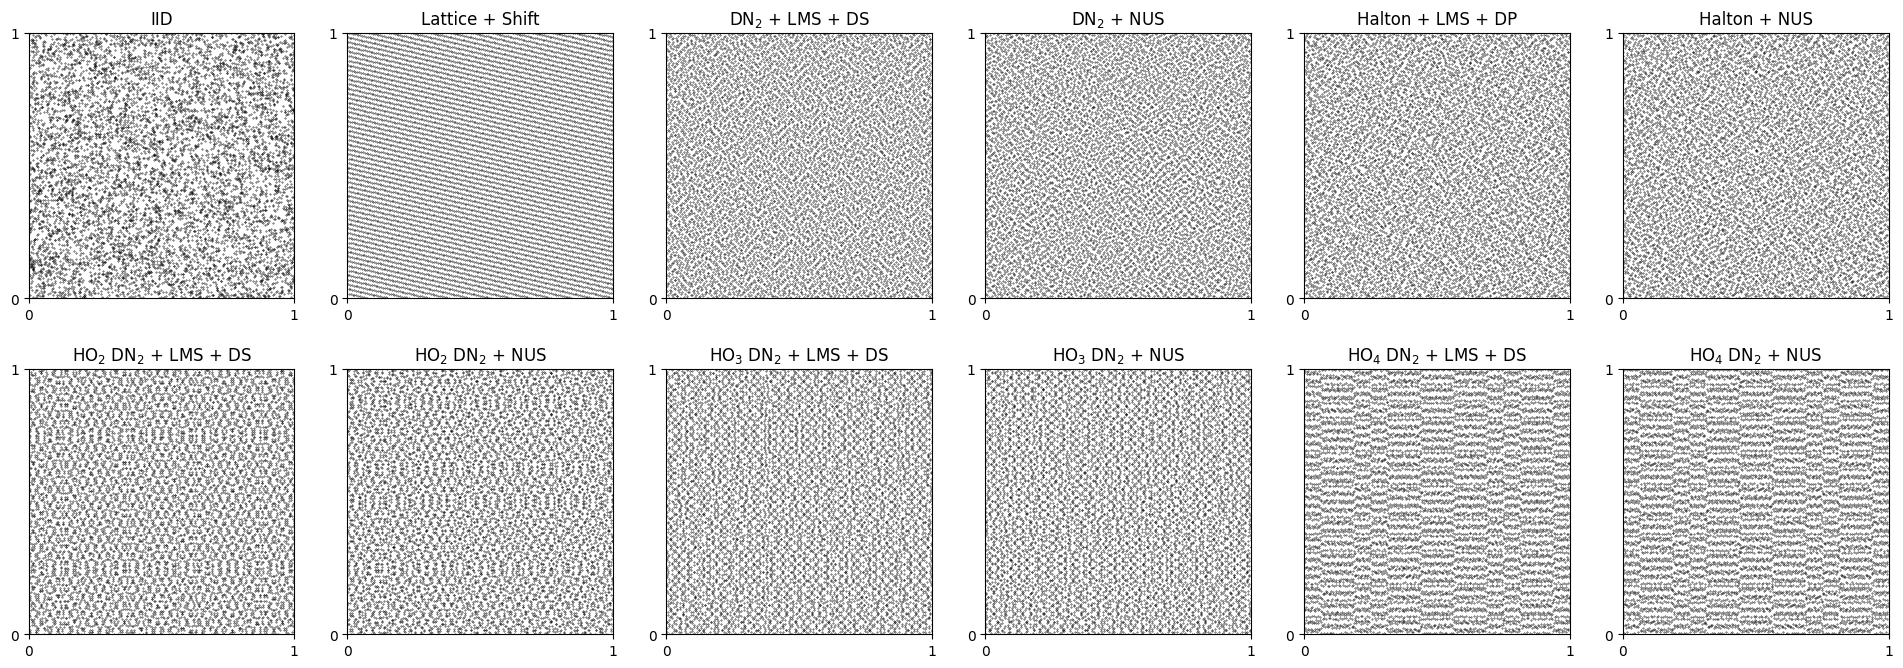

In [9]:
nrows,ncols = 2,6
assert len(pointsets)==(nrows*ncols)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*4,nrows*4))
color = "black"
s = .1
for i,(name,x) in enumerate(pointsets.items()):
    ri,ci = i//ncols,i%ncols
    ax[ri,ci].set_title(name)
    ax[ri,ci].scatter(x[:,0],x[:,1],color=color,s=s)
    ax[ri,ci].set_xlim([0,1]); ax[ri,ci].set_xticks([0,1])
    ax[ri,ci].set_ylim([0,1]); ax[ri,ci].set_yticks([0,1])
    ax[ri,ci].set_aspect(1)
fig.savefig("./pointsets.png",dpi=512,bbox_inches="tight")#,format="png")

## Generation time

In [10]:
r = 1
d = 1
reps = 11
m_max = 20

In [11]:
def time_block(pointsets_fns,names):
    p = len(pointsets_fns)
    t = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    times = np.empty(reps,dtype=np.float64)
    for i in range(p):
        print("%25s: "%names[i],end="",flush=True)
        generator = pointsets_fns[i]
        for m in range(0,m_max+1):
            print("%d, "%m,end='',flush=True)
            for r in range(reps):
                t0 = time.process_time()
                x = generator(2**m)
                times[r] = time.process_time()-t0
            t[i,m] = np.mean(times)
            if t[i,m]>=1: break
        print()
    return t 

In [12]:
pointsets_noho_fns = [
    lambda n: qp.IIDStdUniform(d,replications=r).gen_samples(n),
    lambda n: qp.Lattice(d,replications=r).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r).gen_samples(n),
    lambda n: qp.Halton(d,randomize="LMS_DS",replications=r).gen_samples(n),
    lambda n: qp.Halton(d,randomize="NUS",replications=r).gen_samples(n),]
names_noho = [
    "IID",
    "Lattice + Shift",
    r"DN${}_{2}$ + LMS + DS",
    r"DN${}_{2}$ + NUS",
    "Halton + LMS + DP",
    "Halton + NUS",]
t_noho = time_block(pointsets_noho_fns,names_noho)

                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
         DN${}_{2}$ + NUS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
        Halton + LMS + DP: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
             Halton + NUS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 


In [13]:
pointsets_dnb2_lms_ds_ho_fns = [
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=2).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=3).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=4).gen_samples(n),]
names_dnb2_lms_ds_ho_fns = [
    r"$\alpha = %d$"%2,
    r"$\alpha = %d$"%3,
    r"$\alpha = %d$"%4,]
t_dnb2_lms_ds_ho = time_block(pointsets_dnb2_lms_ds_ho_fns,names_dnb2_lms_ds_ho_fns)

             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


In [14]:
pointsets_dnb2_nus_ho_fns = [
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=2).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=3).gen_samples(n),
    lambda n: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=4).gen_samples(n),]
names_dnb2_nus_ho = [
    r"$\alpha = %d$"%2,
    r"$\alpha = %d$"%3,
    r"$\alpha = %d$"%4,]
t_dnb2_nus_ho = time_block(pointsets_dnb2_nus_ho_fns,names_dnb2_nus_ho)

             $\alpha = 2$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
             $\alpha = 3$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
             $\alpha = 4$: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 


In [15]:
x_fft  = np.random.rand(2**(m_max+1))+1j*np.random.rand(2**(m_max+1))
x_fwht = np.random.rand(2**(m_max+1))
ft_fns = [
    lambda n: qp.fftbr(x_fft[:n]),
    lambda n: qp.ifftbr(x_fft[:n]),
    lambda n: qp.fwht(x_fwht[:n]),]
names_ft = [
    "FFT BR",
    "IFFT BR",
    "FWHT",]
t_ft = time_block(ft_fns,names_ft)

                   FFT BR: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                  IFFT BR: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                     FWHT: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


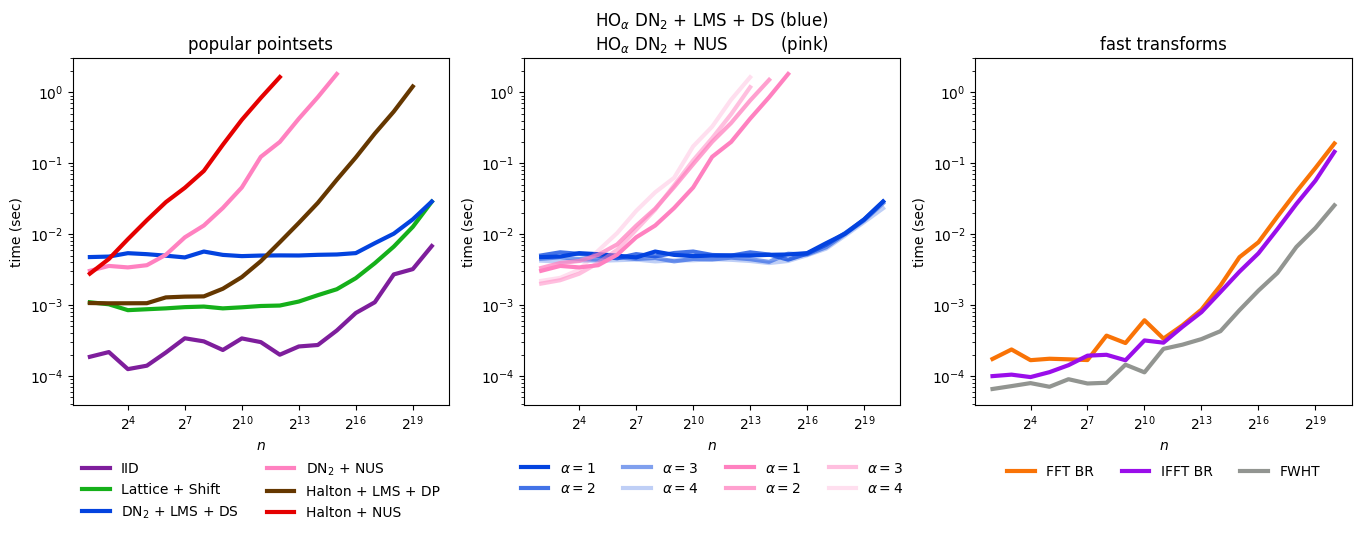

In [16]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(3*5.5,1*4.5),sharey=True,sharex=True)
mvec = np.arange(2,m_max+1)
nvec = 2**mvec
linewidth = 3
ax[0].plot(nvec,t_noho[0,mvec],label=names_noho[0],linewidth=linewidth,color=colors[0])
ax[0].plot(nvec,t_noho[1,mvec],label=names_noho[1],linewidth=linewidth,color=colors[1])
ax[0].plot(nvec,t_noho[2,mvec],label=names_noho[2],linewidth=linewidth,color=colors[2])
ax[0].plot(nvec,t_noho[3,mvec],label=names_noho[3],linewidth=linewidth,color=colors[3])
ax[0].plot(nvec,t_noho[4,mvec],label=names_noho[4],linewidth=linewidth,color=colors[4])
ax[0].plot(nvec,t_noho[5,mvec],label=names_noho[5],linewidth=linewidth,color=colors[5])
ax[1].plot(nvec,t_noho[2,mvec],label=r"$\alpha = 1$",linewidth=linewidth,color=colors[2])
ax[1].plot(nvec,t_dnb2_lms_ds_ho[0,mvec],label=names_dnb2_lms_ds_ho_fns[0],linewidth=linewidth,color=colors[2],alpha=.75)#linestyle=(0, (5, 1)))
ax[1].plot(nvec,t_dnb2_lms_ds_ho[1,mvec],label=names_dnb2_lms_ds_ho_fns[1],linewidth=linewidth,color=colors[2],alpha=.50)#linestyle=(0, (5, 5)))
ax[1].plot(nvec,t_dnb2_lms_ds_ho[2,mvec],label=names_dnb2_lms_ds_ho_fns[2],linewidth=linewidth,color=colors[2],alpha=.25)#linestyle=(0, (5, 10)))
ax[1].plot(nvec,t_noho[3,mvec],label=r"$\alpha = 1$",linewidth=linewidth,color=colors[3])
ax[1].plot(nvec,t_dnb2_nus_ho[0,mvec],label=names_dnb2_nus_ho[0],linewidth=linewidth,color=colors[3],alpha=.75)#linestyle=(0, (5, 1)))
ax[1].plot(nvec,t_dnb2_nus_ho[1,mvec],label=names_dnb2_nus_ho[1],linewidth=linewidth,color=colors[3],alpha=.50)#linestyle=(0, (5, 5)))
ax[1].plot(nvec,t_dnb2_nus_ho[2,mvec],label=names_dnb2_nus_ho[2],linewidth=linewidth,color=colors[3],alpha=.25)#linestyle=(0, (5, 10)))
ax[2].plot(nvec,t_ft[0,mvec],label=names_ft[0],linewidth=linewidth,color=colors[6])
ax[2].plot(nvec,t_ft[1,mvec],label=names_ft[1],linewidth=linewidth,color=colors[7])
ax[2].plot(nvec,t_ft[2,mvec],label=names_ft[2],linewidth=linewidth,color=colors[8])
ax[0].set_title("popular pointsets")
ax[1].set_title(r"HO${}_{\alpha}$ DN${}_{2}$ + LMS + DS (blue)"+"\n"+r"HO${}_{\alpha}$ DN${}_{2}$ + NUS          (pink)")
ax[2].set_title("fast transforms")
ax[0].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.37),ncol=2)
ax[1].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.3),ncol=4)
ax[2].legend(loc="lower center",frameon=False,bbox_to_anchor=(.5,-.25),ncol=3)
ax[0].set_xscale('log',base=2)
for i in range(3):
    ax[i].set_xlabel(r'$n$')
    ax[i].set_ylabel('time (sec)')
#ax[0].set_xlim([nvec.min(),nvec.max()])
#ax[0].set_xticks(nvec)
ax[0].set_yscale('log',base=10)
for i in range(3):
    ax[i].yaxis.set_tick_params(labelleft=True)
fig.savefig("./timing.png",dpi=512,bbox_inches="tight")#,format="png")

## Convergence

In [72]:
r = 300
m_max = 13
seed = 7

In [73]:
def convergence_block(integrand, pointsets_fns, names):
    d = integrand.true_measure.discrete_distrib.d
    p = len(pointsets_fns)
    t = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    muhat = np.nan*np.empty((p,m_max+1),dtype=np.float64) 
    rmse = np.nan*np.empty((p,m_max+1),dtype=np.float64)
    for i in range(p):
        print("%25s: "%names[i],end="",flush=True)
        generator = pointsets_fns[i]
        for m in range(0,m_max+1):
            print("%d, "%m,end='',flush=True)
            t0 = timeit.default_timer()
            x = generator(2**m,d)
            t[i,m] = timeit.default_timer()-t0
            y = np.stack([integrand.f(x[i]) for i in range(r)])[:,:,0]
            muhats = y.mean(1)
            muhat[i,m] = muhats.mean()
            mse = np.mean((muhats-muhat[i,m])**2/(r*(r-1)))
            rmse[i,m] = np.sqrt(mse)
        print()
    return t,muhat,rmse

In [74]:
funcs = [
    qp.CustomFun(
        qp.Uniform(qp.IIDStdUniform(1)),
        lambda x: x[:,0]*np.exp(x[:,0])-1.),
    qp.CustomFun(
        qp.Uniform(qp.IIDStdUniform(2)),
        lambda x: x[:,1]*np.exp(x[:,0]*x[:,1])/(np.exp(1)-2)-1),
    qp.Genz(qp.IIDStdUniform(3),kind_func='oscillatory',kind_coeff=3),
    qp.Genz(qp.IIDStdUniform(3),kind_func='corner-peak',kind_coeff=2),
]
nfuncs = len(funcs)

In [75]:
pointsets_noho_fns = [
    lambda n,d: qp.IIDStdUniform(d,replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.Lattice(d,replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=2).gen_samples(n),
    lambda n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=3).gen_samples(n),]
names_noho = [
    "IID",
    "Lattice + Shift",
    r"DN${}_{2}$ + LMS + DS",
    r"HO${}_2$ DN${}_{2}$ + LMS + DS",
    r"HO${}_3$ DN${}_{2}$ + LMS + DS"]
data_noho = [convergence_block(func,pointsets_noho_fns,names_noho) for func in funcs]

                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
HO${}_2$ DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
HO${}_3$ DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
HO${}_2$ DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
HO${}_3$ DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
                      IID: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
          Lattice + Shift: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
    DN${}_{2}$ + LMS + DS: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
HO${}_2$ DN${}_{2}

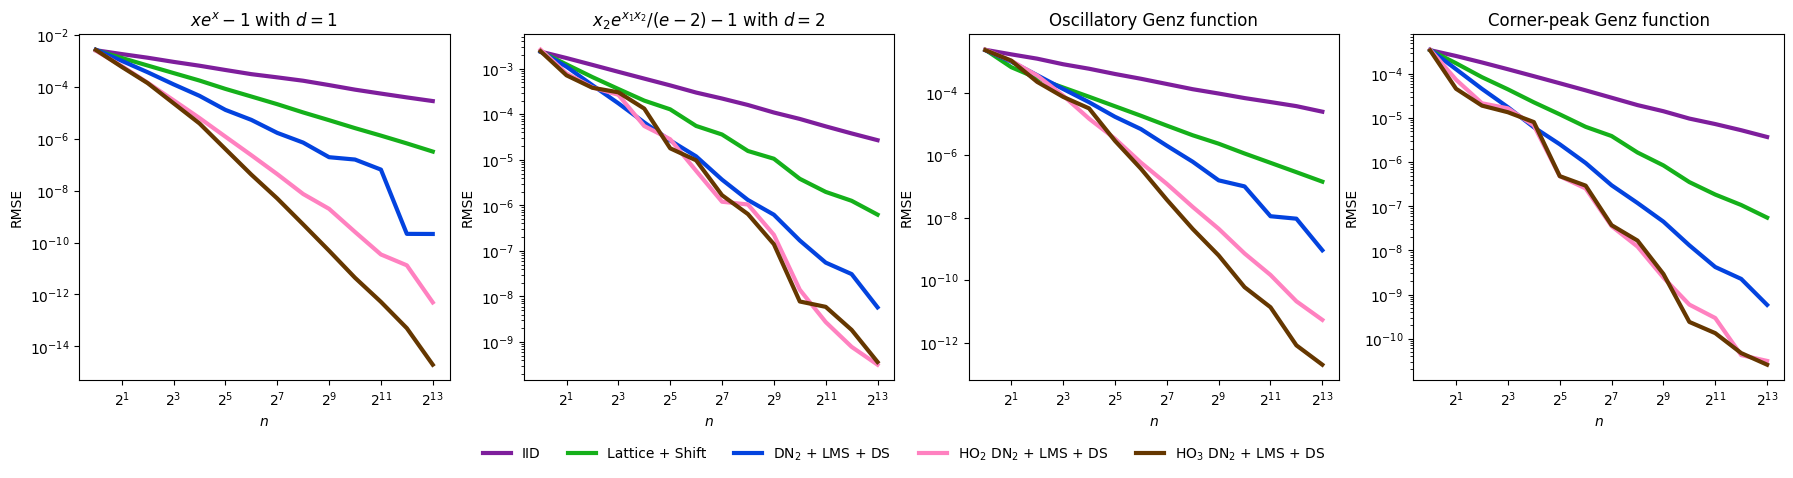

In [96]:
fig,ax = pyplot.subplots(nrows=1,ncols=nfuncs,figsize=(nfuncs*5.5,1*4.5),sharey=False,sharex=True)
ax = np.atleast_1d(ax)
mvec = np.arange(0,m_max+1)
nvec = 2**mvec
linewidth = 3
for i in range(nfuncs):
    t_noho,muhat_noho,rmse_noho = data_noho[i]
    avgi = rmse_noho[:,mvec[0]].mean()
    for j in range(len(t_noho)):
        ax[i].plot(nvec,rmse_noho[j,mvec],label=(names_noho[j] if i==0 else None),linewidth=linewidth,color=colors[j])

    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[0,mvec],label=names_dnb2_lms_ds_ho_fns[0],linewidth=linewidth,color=colors[0])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[1,mvec],label=names_dnb2_lms_ds_ho_fns[1],linewidth=linewidth,color=colors[1])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[2,mvec],label=names_dnb2_lms_ds_ho_fns[2],linewidth=linewidth,color=colors[2])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[3,mvec],label=names_dnb2_lms_ds_ho_fns[3],linewidth=linewidth,color=colors[3])
    # ax[i,1].plot(nvec,rmse_dnb2_lms_ds_ho[4,mvec],label=names_dnb2_lms_ds_ho_fns[4],linewidth=linewidth,color=colors[4])

    # t_dnb2_nus_ho,muhat_dnb2_nus_ho,rmse_dnb2_nus_ho = convergence_block(d,func,pointsets_dnb2_nus_ho_fns,names_dnb2_nus_ho)
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[0,mvec],label=names_dnb2_nus_ho[0],linewidth=linewidth,color=colors[0])
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[1,mvec],label=names_dnb2_nus_ho[1],linewidth=linewidth,color=colors[1])
    # ax[i,2].plot(nvec,rmse_dnb2_nus_ho[2,mvec],label=names_dnb2_nus_ho[2],linewidth=linewidth,color=colors[2])

    # for p in [-1/2,-1.,-3/2,-5/2,-7/2]:
    #     n0 = 2**mvec[0]
    #     kappa = avgi/(n0**p)
    #     nf = 2**mvec[-1]
    #     ax[i].plot([nvec[0],nvec[-1]],[kappa*n0**p,kappa*nf**p])
        
    ax[i].set_yscale('log',base=10)
    ax[i].set_ylabel("RMSE")
    ax[i].set_xlabel(r"$n$")
fig.legend(frameon=False,loc="lower center",bbox_to_anchor=(.5,-.1),ncol=5)
    
    
ax[0].set_xscale('log',base=2)
ax[0].set_title(r"$xe^x-1$ with $d=1$");
ax[1].set_title(r"$x_2 e^{x_1x_2}/(e-2)-1$ with $d=2$");
ax[2].set_title(r"Oscillatory Genz function");
ax[3].set_title(r"Corner-peak Genz function");
#x[:,1]*np.exp(x[:,0]*x[:,1])/(np.exp(1)-2)-1)
#fig.savefig("./convergence.png",dpi=128,bbox_inches="tight")#,format="png")

## Kernel Methods

In [27]:
d = 10 # dimension

mvec = np.arange(21)
nvec = 2**mvec
numm = len(mvec)
y = np.random.rand(2**mvec.max())
reps = 11

def time_kernel_method(get_K, mmax=None):
    tinit = np.nan*np.ones((reps,numm))
    tmult = np.nan*np.ones((reps,numm))
    tsolve = np.nan*np.ones((reps,numm))
    print("\tm from %d to %d: "%(mvec.min(),mvec.max()),end='',flush=True)
    for i,m in enumerate(mvec):
        print("%d, "%m,end='',flush=True)
        n = nvec[i]
        for r in range(reps):
            t0 = time.perf_counter()
            K = get_K(n)
            tinit[r,i] = time.perf_counter()-t0
            t0 = time.perf_counter() 
            a = K@y[:n]
            tmult[r,i] = time.perf_counter()-t0
            #    solve 
            t0 = time.perf_counter()
            b = K.solve(y[:n])
            tsolve[r,i] = time.perf_counter()-t0
        if tinit[:,i].mean()>10 or (mmax is not None and m==mmax): break 
    print()
    return np.median(tinit,0),np.median(tmult,0),np.median(tsolve,0)
    
print("K_std")
def get_K_std(n):
    kernel_gauss  = qp.KernelGaussian( # matching kernel 
        dimension = d,
        scale = 2.,
        lengthscales = 0.1*np.ones(d,dtype=float))
    x = np.random.rand(n,d)
    K_std = qp.GramMatrix( # n x n Gram matrix (only requires size n storage)
        x1 = x, 
        x2 = x,
        kernel_obj = kernel_gauss)
    return K_std
tinit_std,tmult_std,tsolve_std = time_kernel_method(get_K_std,mmax=12)

print("K_lat")
def get_K_lat(n):
    kernel_si  = qp.KernelShiftInvar( # matching kernel 
        dimension = d,
        scale = 2.,
        lengthscales = 0.1*np.ones(d,dtype=float), 
        alpha = 4*np.ones(d,dtype=int))
    dd_obj = qp.Lattice(dimension=d, seed=7) # discrete distribution
    K_lat = qp.FastGramMatrixLattice( # n x n Gram matrix (only requires size n storage)
        dd_obj = dd_obj, 
        kernel_obj = kernel_si, 
        n1 = n, n2 = n)
    return K_lat
tinit_lat,tmult_lat,tsolve_lat = time_kernel_method(get_K_lat)

print("K_dn3")
def get_K_dn3(n):
    kernel_dsi  = qp.KernelDigShiftInvar( # matching kernel 
        dimension = d,
        scale = 2.,
        # scalars passed to lengthscales and alpha get copied to each dimension
        # one may also pass length d vectors for these arguments 
        lengthscales = 0.1*np.ones(d,dtype=float), 
        alpha = 3*np.ones(d,dtype=int))
    dd_obj = qp.DigitalNetB2(dimension=d, seed=7) # discrete distribution
    K_dn = qp.FastGramMatrixDigitalNetB2( # n x n Gram matrix (only requires size n storage)
        dd_obj = dd_obj, 
        kernel_obj = kernel_dsi, 
        n1 = n, n2 = n)
    return K_dn
tinit_dn3,tmult_dn3,tsolve_dn3 = time_kernel_method(get_K_dn3)

print("K_dn4")
def get_K_dn4(n):
    kernel_dsi  = qp.KernelDigShiftInvar( # matching kernel 
        dimension = d,
        scale = 2.,
        # scalars passed to lengthscales and alpha get copied to each dimension
        # one may also pass length d vectors for these arguments 
        lengthscales = 0.1*np.ones(d,dtype=float), 
        alpha = 4*np.ones(d,dtype=int))
    dd_obj = qp.DigitalNetB2(dimension=d, seed=7) # discrete distribution
    K_dn = qp.FastGramMatrixDigitalNetB2( # n x n Gram matrix (only requires size n storage)
        dd_obj = dd_obj, 
        kernel_obj = kernel_dsi, 
        n1 = n, n2 = n)
    return K_dn
tinit_dn4,tmult_dn4,tsolve_dn4 = time_kernel_method(get_K_dn3)

K_std
	m from 0 to 20: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
K_lat
	m from 0 to 20: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
K_dn3
	m from 0 to 20: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
K_dn4
	m from 0 to 20: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 


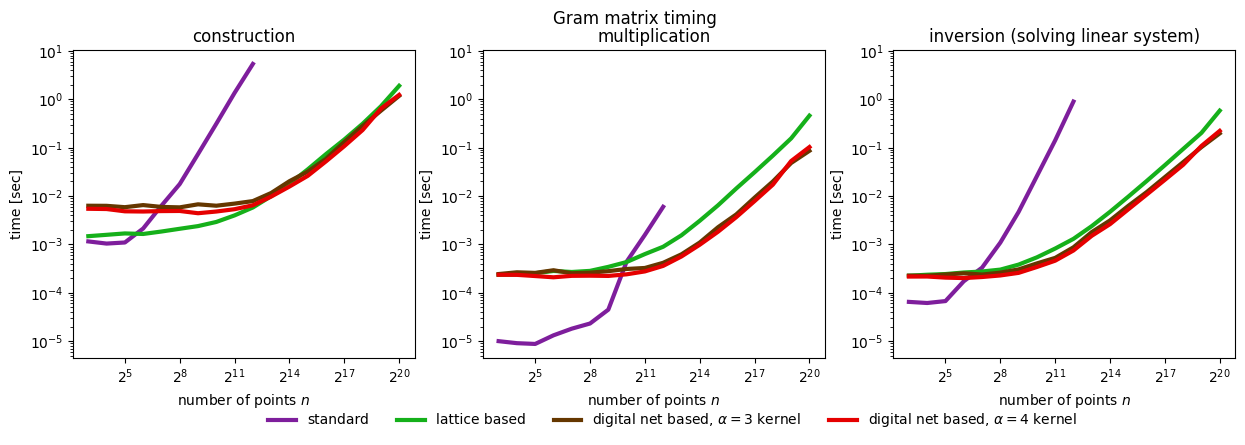

In [28]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(3*5,1*4),sharey=True,sharex=True)
ax = np.atleast_2d(ax)
linewidth = 3
s = 3
ax[0,0].set_title("construction")
ax[0,0].plot(nvec[s:],tinit_std[s:],label="standard",linewidth=linewidth,color=colors[0])
ax[0,0].plot(nvec[s:],tinit_lat[s:],label="lattice based",linewidth=linewidth,color=colors[1])
ax[0,0].plot(nvec[s:],tinit_dn3[s:],label=r"digital net based, $\alpha = 3$ kernel",linewidth=linewidth,color=colors[4])
ax[0,0].plot(nvec[s:],tinit_dn4[s:],label=r"digital net based, $\alpha = 4$ kernel",linewidth=linewidth,color=colors[5])
ax[0,1].set_title("multiplication")
ax[0,1].plot(nvec[s:],tmult_std[s:],linewidth=linewidth,color=colors[0])
ax[0,1].plot(nvec[s:],tmult_lat[s:],linewidth=linewidth,color=colors[1])
ax[0,1].plot(nvec[s:],tmult_dn3[s:],linewidth=linewidth,color=colors[4])
ax[0,1].plot(nvec[s:],tmult_dn4[s:],linewidth=linewidth,color=colors[5])
ax[0,2].set_title("inversion (solving linear system)")
ax[0,2].plot(nvec[s:],tsolve_std[s:],linewidth=linewidth,color=colors[0])
ax[0,2].plot(nvec[s:],tsolve_lat[s:],linewidth=linewidth,color=colors[1])
ax[0,2].plot(nvec[s:],tsolve_dn3[s:],linewidth=linewidth,color=colors[4])
ax[0,2].plot(nvec[s:],tsolve_dn4[s:],linewidth=linewidth,color=colors[5])
ax[0,0].set_yscale("log",base=10)
ax[0,0].set_xscale("log",base=2)
for i,j in itertools.product(range(ax.shape[0]),range(ax.shape[1])):
    ax[i,j].set_ylabel("time [sec]")
    ax[i,j].set_xlabel(r"number of points $n$")
    ax[i,j].yaxis.set_tick_params(labelleft=True)
fig.suptitle("Gram matrix timing")
fig.legend(frameon=False,loc="lower center",bbox_to_anchor=(.525,-.1),ncol=10)
fig.savefig("./kernel_methods.png",dpi=128,bbox_inches="tight")#,format="png")

## Kernels

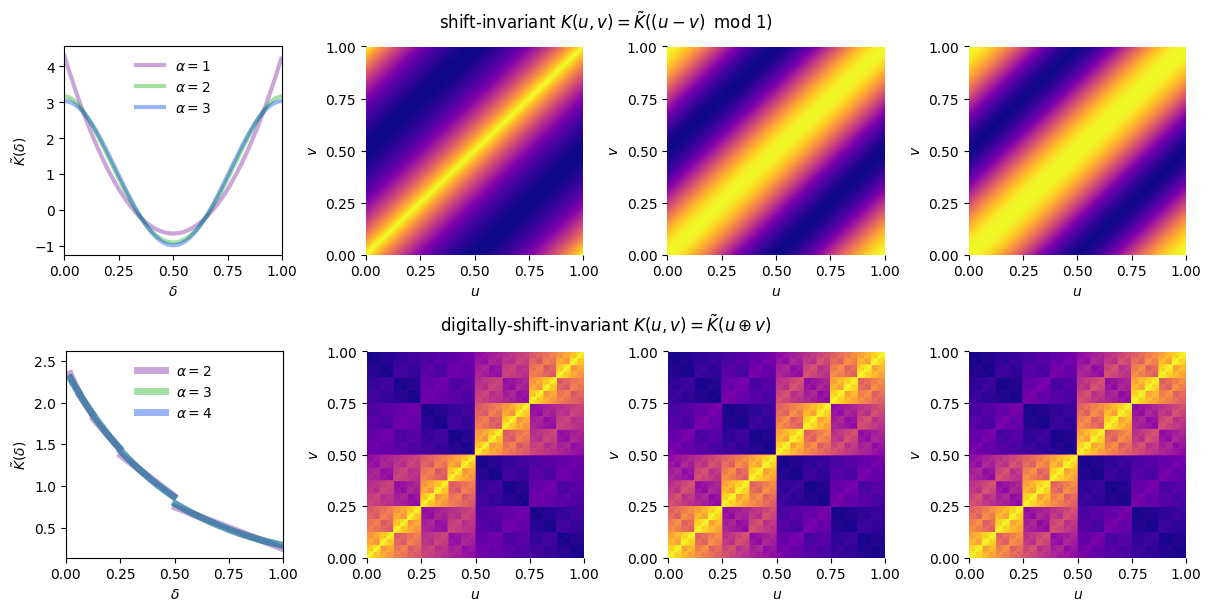

In [29]:
nrows = 2
ncols = 4
m = 8
n = 2**m
fig = pyplot.figure(figsize=(3*ncols,3*nrows),constrained_layout=True)
subfigs = fig.subfigures(nrows=2,ncols=1)
subfigs[0].suptitle(r"shift-invariant $K(u,v) = \tilde{K}((u-v) \;\;\mathrm{mod}\; 1)$")
subfigs[1].suptitle(r"digitally-shift-invariant $K(u,v) = \tilde{K}(u \oplus v)$")
ax = np.vstack([subfigs[0].subplots(ncols=4),subfigs[1].subplots(ncols=4)])
xi = np.arange(n) 
xf = xi/n
x1im,x2im = np.meshgrid(xi,xi)
x1i,x2i = x1im.reshape((-1,1)),x2im.reshape((-1,1))
x1m,x2m = x1im/n,x2im/n
x1,x2 = x1m.reshape((-1,1)),x2m.reshape((-1,1))
# lattice 
for i,alpha in enumerate([1,2,3]):
    kernel_l = qp.KernelShiftInvar(1,alpha=alpha)
    y = np.array([kernel_l(x1[[i]],x2[[0]]) for i in range(n)]).flatten()
    ax[0,0].plot(xf,y,label=r"$\alpha = %d$"%alpha,linewidth=3,color=colors[i],alpha=.4)
    ym = np.array([kernel_l(x1[[i]],x2[[i]]) for i in range(n*n)]).reshape((n,n))
    ax[0,i+1].contourf(x1m,x2m,ym,cmap="plasma",levels=100)#,antialiased=True)
# digital net
for i,alpha in enumerate([2,3,4]):
    kernel_d = qp.KernelDigShiftInvar(1,alpha=alpha,t=m)
    y = np.array([kernel_d(x1i[[i]],x2i[[0]]) for i in range(n)]).flatten()
    y[2**np.arange(m)] = np.nan
    ax[1,0].plot(xf,y,label=r"$\alpha = %d$"%alpha,linewidth=5,color=colors[i],alpha=.4)
    ym = np.array([kernel_d(x1i[[i]],x2i[[i]]) for i in range(n*n)]).reshape((n,n))
    ax[1,i+1].contourf(x1m,x2m,ym,cmap="plasma",levels=100)#,antialiased=True)
for i in range(nrows):
    ax[i,0].legend(frameon=False,loc="upper center",ncols=1)
    ax[i,0].set_xlabel(r"$\delta$")
    ax[i,0].set_ylabel(r"$\tilde{K}(\delta)$")
    for j in range(ncols):
        ax[i,j].set_xlim([0,1]); ax[i,j].set_xticks([0,.25,.5,.75,1])
        if j>=1:
            for spine in ax[i,j].spines.values(): spine.set_visible(False)
            ax[i,j].set_ylim([0,1]); ax[i,j].set_yticks([0,.25,.5,.75,1])
            ax[i,j].set_xlabel(r"$u$")
            ax[i,j].set_ylabel(r"$v$")
fig.savefig("./kernels.png",dpi=128,bbox_inches="tight")#,format="png")